# Getting Data from Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/IMBD.zip

Archive:  /content/drive/MyDrive/IMBD.zip
   creating: IMBD/
  inflating: IMBD/imdb_dataset.csv   
  inflating: IMBD/unlabeled.csv      


# Import Important libararies

In [3]:
!pip install torchtext==0.6.0 torch==1.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch

In [4]:
import pandas as pd
import nltk
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import math
from tqdm import tqdm
import os
import copy
import platform
import pickle
from torchtext import data
import re
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
SEED = 42

# Checking Device
Set the Device to GPU or CPU.

In [6]:
# Check If the a GPU is available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('GPU is not available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Data loading and Pre_Processing

##### Read Dataset

In [7]:
reviews = pd.read_csv("/content/IMBD/imdb_dataset.csv")

##### Dimensions of Data

In [8]:
reviews.shape

(48000, 2)

##### Peak at the Data

In [9]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
reviews.tail()

,review,sentiment
47995,"First of all, Blythe Danner doesn't look anywh...",negative
47996,I wouldn't be so quick to look at all the good...,negative
47997,Everything about this show is terrible. Its pr...,negative
47998,This movie just was not very funny. There's no...,negative
47999,"""The Yoke's on Me"" is undoubtedly the most con...",negative


##### Attributes in Data

In [11]:
reviews.columns

Index(['review', 'sentiment'], dtype='object')

##### Describe the Data

In [12]:
reviews.describe()

,review,sentiment
count,48000,48000
unique,47622,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,24000


It means there are some Duplicate Records in the data. 

Let's use groupby to use describe by label, this way we can begin to think about the features that separate Pos and Neg!

In [13]:
reviews.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   24000  23724  I see that C. Thomas Howell has appeared in ma...   
positive   24000  23898  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

### Text Pre-processing

##### Check Null Values

In [14]:
reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

##### Check Duplicate Recode

In [15]:
reviews.review.duplicated().sum()

378

In [16]:
reviews.drop_duplicates(subset=['review'],keep='first',inplace=True) # drop duplicates and kepp one of them

##### Clean Text
Let's create a function that will process the string in the review column, then we can just use apply() in pandas do process all the text in the DataFrame.

In [17]:
stopwords = set(nltk.corpus.stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

In [18]:
def preprocess(text, english_words, stopwords):
    
    text = text.lower()
    html_tag = '<.*?>'
    text = re.sub(html_tag, '', text)
    # Removing Punctuation marks
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    rem_punc = tokenizer.tokenize(text)
    # Removing Stop Words
    rem_stop_words = [word for word in rem_punc if not word in stopwords]
    english_words = [word for word in rem_stop_words if word in english_words]
    sentence = ' '.join(english_words)
    
    return sentence

In [19]:
test_example = 'I was not happy, then i visited Naran, such a beautiful place. Now I am in love with that place'

In [20]:
clean_example = preprocess(test_example, english_words, stopwords)

In [21]:
clean_example

'happy beautiful place love place'

In [22]:
reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [23]:
reviews['review'] = reviews['review'].apply(lambda x : preprocess(x, english_words, stopwords))

In [24]:
reviews['review'][3]

'basically family little boy jake zombie closet fighting time movie soap opera suddenly jake become kill zombie first going make film must decide thriller drama drama movie watchable like real life jake closet totally film see similar movie instead watched drama meaningless thriller well descent jake ignore'

#### Label Encoidng

In [25]:
reviews['sentiment'] = reviews['sentiment'].map( {'positive':1, 'negative': 0} ).astype(int)

### Exploratory Data Analysis

Let's make a new column to detect how long the text messages are:

In [26]:
reviews['length'] = reviews['review'].str.len() #check Leanth of Each tweet
reviews.head()

,review,sentiment,length
0,one watching episode hooked right exactly firs...,1,757
1,wonderful little production technique unassumi...,1,458
2,thought wonderful way spend time hot summer we...,1,470
3,basically family little boy jake zombie closet...,0,307
4,petter love time money visually stunning film ...,1,620


In [27]:
reviews.length.describe()

count    47622.000000
mean       607.156377
std        461.739841
min         17.000000
25%        323.000000
50%        451.000000
75%        739.000000
max       6378.000000
Name: length, dtype: float64

Maximum tweet leanth is 6378, which is very long and as we see mean is 607. We will remove long tweets. We will remove top 100 indexes with maximum length.

In [28]:
reviews = reviews.sample(frac=1,random_state=SEED).reset_index(drop=True) #shuffle data frame

### Data Visualization

<ipython-input-29-248dcc1250ff>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reviews['length'],bins=25)


<Axes: xlabel='length', ylabel='Density'>

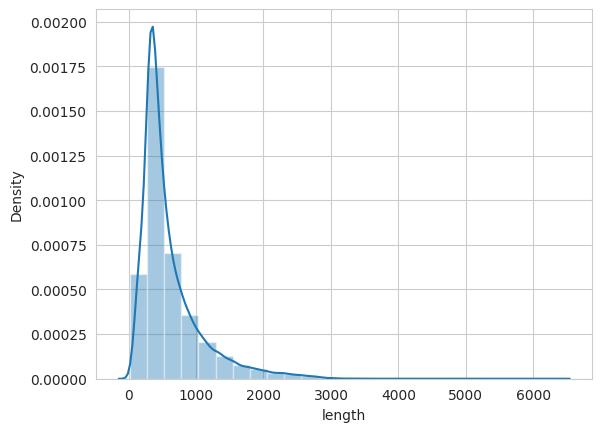

In [29]:
sns.set_style('whitegrid')
sns.distplot(reviews['length'],bins=25)

Most of the reviews are between 0 to 1000 lengths. Now we will remove top 100 indexes with maximum length.

In [30]:
np.sort(-reviews['length'])[0:100]

array([-6378, -6343, -5785, -5586, -4786, -4641, -4560, -4205, -4154,
       -4140, -4099, -4006, -3784, -3720, -3677, -3546, -3541, -3447,
       -3440, -3324, -3292, -3235, -3205, -3195, -3188, -3182, -3164,
       -3159, -3116, -3047, -3043, -3042, -3037, -3032, -3021, -3020,
       -3015, -3012, -3005, -2999, -2997, -2997, -2993, -2987, -2987,
       -2977, -2975, -2962, -2957, -2944, -2937, -2932, -2932, -2929,
       -2928, -2922, -2911, -2907, -2896, -2884, -2879, -2878, -2877,
       -2877, -2874, -2871, -2868, -2868, -2867, -2867, -2861, -2859,
       -2852, -2850, -2850, -2850, -2848, -2843, -2843, -2841, -2841,
       -2840, -2839, -2838, -2835, -2832, -2832, -2831, -2829, -2828,
       -2819, -2819, -2814, -2814, -2812, -2812, -2810, -2804, -2801,
       -2799])

In [31]:
reviews.drop(reviews.index[np.argsort(-reviews['length'])[0:100]],axis=0,inplace=True)

In [32]:
reviews.length.describe()

count    47522.000000
mean       601.662472
std        445.201237
min         17.000000
25%        322.000000
50%        450.000000
75%        736.000000
max       2797.000000
Name: length, dtype: float64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

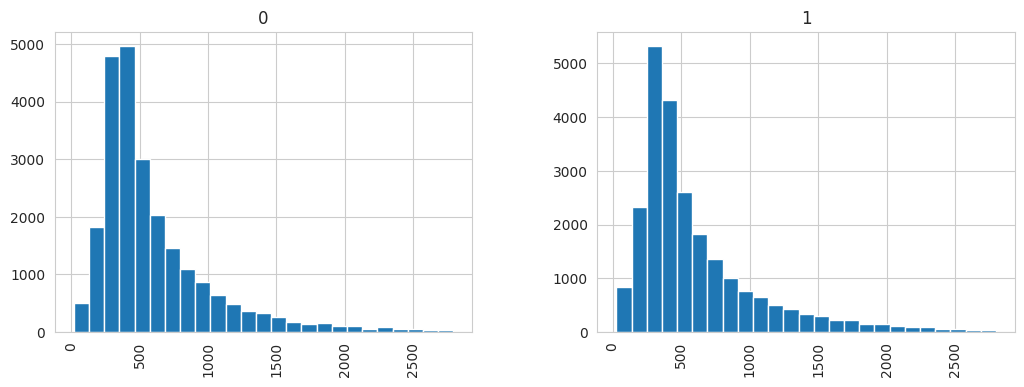

In [33]:
reviews.hist(column='length', by='sentiment', bins=25,figsize=(12,4))

<Axes: xlabel='sentiment', ylabel='count'>

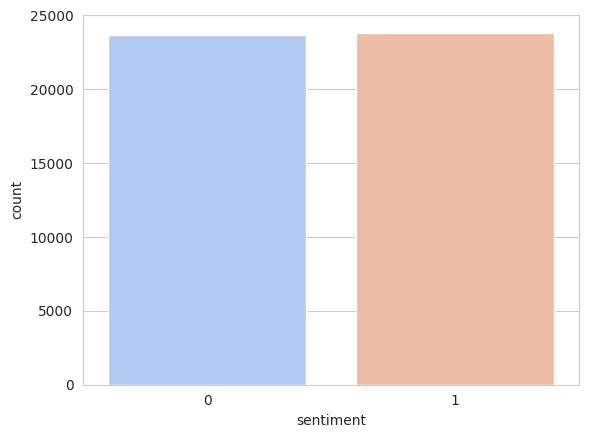

In [34]:
sns.countplot(x='sentiment',data=reviews,palette='coolwarm')

#### Save the clean data

In [35]:
reviews = reviews.sample(frac=1,random_state=SEED).reset_index(drop=True) #shuffle data frame
reviews.to_csv('/content/IMBD/clean.csv',index = False)

### TorchText
We will use the torchtext for loading the data and also do encoding with torchtext.

##### Load the dataset
We will load the dataset and create a vocab and resturn dataloader.

In [36]:
import random
def loadDataset(fix_length, batch_size,embedding_vector = '100'):
    
    # define the columns
    TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  init_token='<start>',
                  eos_token='<end>',
                 fix_length = fix_length)
    
    LABEL = data.LabelField(dtype = torch.long)
    
    # create tuples representing the columns
    fields = [
      ('review', TEXT),
      ('sentiment',LABEL)
    ]
    
    #### Create the Dataset
    dataset = data.TabularDataset.splits(
                                          path='/content/IMBD',
                                          train = 'clean.csv',
                                          format = 'csv',
                                          fields = fields,
                                          skip_header = True,
                                         )
    
    ## Split the data
    # train_data, test_data = dataset.split(split_ratio=0.7, random_state = SEED)
    # train_data, valid_data = train_data.split(split_ratio=0.8, random_state = SEED)
    train_data, valid_data, test_data = dataset[0].split(split_ratio=[0.7, 0.1, 0.2], stratified=True,
                                                         strata_field='sentiment', random_state=random.seed(SEED))
    print(f'Number of training examples: {len(train_data)}')
    print(f'Number of validation examples: {len(valid_data)}')
    print(f'Number of testing examples: {len(test_data)}')
    
    ### create Vocab
    MAX_VOCAB_SIZE = 30_000
    if embedding_vector == '300':
        
        TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.300d", 
                         unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(train_data)
    else:
        TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.100d", 
                         unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(train_data)
        
    ### create the Dataloader
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                                                (train_data, valid_data, test_data), 
                                                                                batch_size = batch_size,
                                                                                sort_key = lambda x: x.review,
                                                                                sort_within_batch = True,
                                                                                device = device)
    
    return train_iterator, valid_iterator, test_iterator, TEXT

In [37]:
train_loader, val_loader, test_loader, TEXT = loadDataset(700, 32)

Number of training examples: 33265
Number of validation examples: 9505
Number of testing examples: 4752


.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21806.57it/s]


In [38]:
next(iter(train_loader))


[torchtext.data.batch.Batch of size 32]
	[.review]:('[torch.cuda.LongTensor of size 700x32 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.sentiment]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [39]:
batch = next(iter(train_loader))
vars(batch)

{'batch_size': 32,
 'dataset': <torchtext.data.dataset.Dataset at 0x7f458ace7340>,
 'fields': dict_keys(['review', 'sentiment']),
 'input_fields': ['review'],
 'target_fields': ['sentiment'],
 'review': (tensor([[   2,    2,    2,  ...,    2,    2,    2],
          [2498,  386,  386,  ...,  336,  336,  336],
          [1035,  387,  387,  ...,  183,    5, 2208],
          ...,
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0'),
  tensor([154,  52,  60, 129, 142, 196,  55,  45, 195,  73,  42,  67,  95,  72,
          130, 110,  93,  88,  57, 125,  45,  26,  49,  66, 103,  73,  49,  88,
           66,  90,  83,  58], device='cuda:0')),
 'sentiment': tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
         1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')}

In [40]:
batch.review[0].shape

torch.Size([700, 32])

In [41]:
len(TEXT.vocab)

28161

In [42]:
# embedding_vector = '300'
# # create dataset loaders
# train_loader, val_loader, test_loader, TEXT, test_dataset = loadDataset(fix_length, batch_size, embedding_vector)
# # intilize the model
# pad_idx = PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
# input_dim = len(TEXT.vocab)

# # define network
# Net = Initialize_Network(type_of_rnn, input_dim,embedding_dim, hidden_dim_per_layer, output_dim, pad_idx, dropout)
# print(Net)
# ### Pretrained Embedding
# pretrained_embeddings = TEXT.vocab.vectors
# Net.embedding.weight.data.copy_(pretrained_embeddings)
# UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
# Net.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
# Net.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

In [43]:
clean_example

'happy beautiful place love place'

In [44]:
TEXT.tokenize(clean_example)

['happy', 'beautiful', 'place', 'love', 'place']

In [45]:
TEXT.pad_token

'<pad>'

In [46]:
temp = clean_example.split()
temp.insert(0,TEXT.init_token)
temp.append(TEXT.eos_token)

In [47]:
temp

['<start>', 'happy', 'beautiful', 'place', 'love', 'place', '<end>']

In [48]:
for pad in range(len(temp),20):
    temp.append(TEXT.pad_token) 

In [49]:
encode = []
for word in temp:
    encode.append(TEXT.vocab.stoi.get(word))

In [50]:
encode

[2, 456, 174, 148, 35, 148, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [51]:
torch.transpose(torch.unsqueeze(torch.tensor(encode),0),0,1)

tensor([[  2],
        [456],
        [174],
        [148],
        [ 35],
        [148],
        [  3],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1]])

In [52]:
example = torch.transpose(torch.unsqueeze(torch.tensor(encode),0),0,1).type(torch.LongTensor)
example

tensor([[  2],
        [456],
        [174],
        [148],
        [ 35],
        [148],
        [  3],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1],
        [  1]])

# Sequence models

### LSTM

In [53]:
class LSTMwrong(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim


        self.W_x = nn.Linear(self.input_dim, 4 * self.hidden_dim, bias=True)
        self.W_h = nn.Linear(self.hidden_dim, 4 * self.hidden_dim, bias=True)


    def lstm_step(self, inp, prev_hidden_cell):     
        
        h_prev , c_prev = prev_hidden_cell
        
        # The activation vector
        activation = self.W_x(inp) + self.W_h(h_prev)
        
        # The activation is split into four parts
        ai, af, ac, ao = activation.chunk(4, dim=1)

        updated_h, updated_c = None, None
      
        # TODO: Implement the gates of lstm and update hidden state and cell state

        in_gate     = torch.sigmoid(ai)
        forget_gate = torch.sigmoid(af)
        cell_gate   =  torch.tanh(ac)
        out_gate    = torch.sigmoid(ao)

        updated_c  = forget_gate * c_prev + in_gate * cell_gate
        updated_h  = out_gate * torch.tanh(cell_gate)
        
        return updated_h, updated_c


    def forward(self, text):
        
        if self.hidden and self.cell_state:
            h = self.hidden
            c = self.cell_state
        else:
            h = torch.zeros(text.shape[1], self.hidden_dim)
            c = torch.zeros(text.shape[1], self.hidden_dim)

        # inp = inp.transpose(0, 1)
        # Loop through the whole sequence and update h_t and c_t at every time step
        # Shape of x is (seq_len, batch_size)
        sequence_outputs = []
        for j in range(text.shape[1]):
        # Get the i-th word in the sequence
            for i in range(text.shape[0]):
                x = self.embedding(text[i, j])
                # print(f'shape of x {x.shape}')
                # print(x)
                # x = F.one_hot(x.squeeze(), num_classes=self.input_dim).float()  # Convert index to one-hot representation
                h, c = self.lstm_step(x.to(device), (h.to(device), c.to(device)))
            sequence_output = self.fc(h)

        return torch.stack(sequence_outputs, dim=1)

In [54]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim, hidden_dim):

        super().__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
                
        self.W_x = nn.Linear(self.input_dim,4 * self.hidden_dim)
        self.W_h = nn.Linear(self.hidden_dim,4 *self.hidden_dim)


    def lstm_step(self, inp, prev_hidden_cell):
        
        h_prev , c_prev = prev_hidden_cell
        
        activation = self.W_x(inp) + self.W_h(h_prev)
                
        # The activation is split into four parts
        ai, af, ac, ao = activation.chunk(4, 1)
        
        updated_h, updated_c = None, None
    
        in_gate     = torch.sigmoid(ai)
        forget_gate = torch.sigmoid(af)
        cell_gate   = torch.sigmoid(ao)
        out_gate    = torch.tanh(ac)

        updated_c  = forget_gate * c_prev + in_gate * out_gate
        updated_h  = cell_gate * torch.tanh(updated_c)

        return updated_h, updated_c


    def forward(self, inp, hidden=None, cell=None):
        
        # input shape (seq_dim, batch_size, input_dim)
        seq_dim,batch_size , _ = inp.shape

        if hidden == None and cell == None:
            # Initialize hidden state with zeros (batch_size, hidden_dim)
            h = torch.zeros((batch_size, self.hidden_dim)).to(device) 
        
            # Initialize cell state with zeros (batch_size, hidden_dim)
            c = torch.zeros((batch_size, self.hidden_dim)).to(device)
        else:
            h = hidden
            c = cell
            
        outputs = []
        # Loop through the whole sequence and update h_t and c_t at every time step
        for x in inp:
           # shape of x is (batch_size, input_dim )
           h, c = self.lstm_step( x, (h, c))
           outputs.append(h)
        
        return h, c, torch.stack(outputs)

### VanilaRNN

In [55]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W_x = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.W_h = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
    

    def forward(self, inputs):
        
        seq_dim, batch_size , input_dim = inputs.shape
        
        hidden = torch.zeros((batch_size, self.hidden_dim)).to(device)
        
        outputs = []
        # Loop through the whole sequence and update hideen state at every time step
        for x in inputs:
            hidden = torch.tanh(self.W_x(x) + self.W_h(hidden))
            outputs.append(hidden)
        
        return hidden, torch.stack(outputs)

### GRU

In [56]:
class GRUwrong(nn.Module):
    
    def __init__(self,input_dim, hidden_dim):

        super().__init__()
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.W_x = nn.Linear(input_dim, 3 * hidden_dim, bias=True)
        self.W_h = nn.Linear(hidden_dim, 3 * hidden_dim, bias=True)

    def gru_step(self, inp, prev_hidden):     

        h_prev = prev_hidden
        
        # Calculate activations
        activation = self.W_x(inp) + self.W_h(h_prev)
        r, z, n = activation.chunk(3, dim=1)

        # Compute reset and update gates
        r = torch.sigmoid(r)
        z = torch.sigmoid(z)

        # Compute candidate activation
        n = torch.tanh(n)

        # Compute hidden state
        h = (1 - z) * n + z * h_prev * r

        return h
      
    def forward(self, inp):

        # Initialize hidden state with zeros (batch_size, hidden_dim)
        if self.hidden:
            h = self.hidden
        else:
            h = torch.zeros(inp.shape[1], self.hidden_dim)
        
        # Loop through the whole sequence and update h_t at every time step
        for x in inp:
            h = self.gru_step(x, h)
        
        return h

In [57]:
class GRU(nn.Module):
    
    def __init__(self,input_dim, hidden_dim):

        super().__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
                
        self.W_x = nn.Linear(self.input_dim,2 * self.hidden_dim)
        self.U_h = nn.Linear(self.hidden_dim,2 *self.hidden_dim)
        
        self.W = nn.Linear(self.input_dim,self.hidden_dim)
        self.U = nn.Linear(self.hidden_dim,self.hidden_dim)


    def GRU_step(self, inp, h_prev):
        
        
        activation = self.W_x(inp) + self.U_h(h_prev)
                
        # The activation is split into 2 parts
        au, ar = activation.chunk(2, 1)
        
        h_t_temp, h_t = None, None
        
        z_t     = torch.sigmoid(au)
        r_t    = torch.sigmoid(ar)

        h_t_temp = torch.tanh(self.W(inp)+(r_t*self.U(h_prev)))
        h_t = (z_t*h_prev) + ((1-z_t)*h_t_temp)

        return h_t


    def forward(self, inp):
        
        # input shape (seq_dim, batch_size, input_dim)
        seq_dim,batch_size , _ = inp.shape

        # Initialize hidden state with zeros (batch_size, hidden_dim)
        hidden = torch.zeros((batch_size, self.hidden_dim)).to(device) 
        
        outputs = []
        # Loop through the whole sequence and update h_t and c_t at every time step
        for x in inp:
            
            hidden = self.GRU_step( x, hidden)
            outputs.append(hidden)
        
        return hidden, torch.stack(outputs)

#### Init_Network

In [58]:
class Initialize_Network(nn.Module):
    
    def __init__(self,type_of_rnn, input_dim,embedding_dim, hidden_dim_per_layer, output_dim, pad_idx, dropout = 0.25):
        
        super(Initialize_Network, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        
        # Initialize rnn model
        self.rnn = nn.ModuleList()
        hidden_dim_per_layer.insert(0,embedding_dim)
        if type_of_rnn == "Vanilla RNN":
            for input_size, output_size in zip(hidden_dim_per_layer, hidden_dim_per_layer[1:]):
                self.rnn.append(RNN(input_size, output_size))
        elif type_of_rnn == "GRU":
            for input_size, output_size in zip(hidden_dim_per_layer, hidden_dim_per_layer[1:]):
                self.rnn.append(GRU(input_size, output_size))
        else:
            for input_size, output_size in zip(hidden_dim_per_layer, hidden_dim_per_layer[1:]):
                self.rnn.append(LSTM(input_size, output_size))
        
        self.drop_layer = nn.Dropout(p=dropout)
        # Initialize FC layer
        self.fc = nn.Linear(hidden_dim_per_layer[-1], output_dim)                                    
        
    def forward(self, x):
        
        embeddeding = self.embedding(x)

        hidden = None
        cell = None
        
        outputs = embeddeding
        L = len(self.rnn)
        for (l, rnn) in zip(range(L), self.rnn):
            hidden, cell, outputs = rnn(outputs, hidden, cell)
            
        hidden = self.drop_layer(hidden.squeeze(0))         
        output = self.fc(hidden)
        
        return output

# Training


### Training Visualize

In [59]:
# this function will plot the accuracy and loss graph of training and validation
def plot_loss_and_accuracy_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(history['train_accuracy'], color='royalblue', label='Train Accuracy')
    ax[0].plot(history['val_accuracy'], color='darkred', label='Validation Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()

    ax[1].plot(history['train_loss'], color='royalblue', label='Train Loss')
    ax[1].plot(history['val_loss'], color='darkred', label='Validation Loss')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation Losses')
    ax[1].legend()
    plt.show()

### Train Function

In [60]:
from pathlib import Path
def train(model, criterion, optimizer, train_loader, validation_loader, model_save_name, epochs, type_of_rnn):
    models_path = './models/'
    # create the Models folder if it's not exit
    Path(models_path).mkdir(parents=True, exist_ok=True)
    
    # loading the model into device i.e cpu or gpu
    model.to(device)
    # making a copy of model
    best_model = copy.deepcopy(model)
    # Defining the history
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [],
                   'epochs': 0, 'best_val_accuracy': -np.inf, 'min_val_loss': np.inf}

    # defining the variable we will use during the training
    best_val_accuracy = history['best_val_accuracy']
    min_val_loss = history['min_val_loss']

    for epoch in range(0, epochs):  # loop over the dataset multiple times

        train_loss = 0.0
        val_loss = 0.0

        train_accuracy = 0.0
        val_accuracy = 0.0

        correct = 0
        # setting the model in training mode
        model.train()
        # defining the tqdm for displaying the results after every epoch
        outer = tqdm(total=len(train_loader.dataset), desc='Train Epoch: %s / %s' % (epoch + 1, epochs),
                     position=0, leave=True)

        # iterate over train loader
        for batch in train_loader:
            # loading the inputs and outputs into device
            inputs, text_lengths = batch.review
            classes = batch.sentiment
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)  # ----> forward pass
            loss = criterion(outputs, classes)  # ----> compute loss

            loss.backward()  # ----> backward pass
            optimizer.step()  # ----> weights update

            # total train loss
            train_loss += loss.item()
            # getting the predicted classes
            _, predicted = torch.max(outputs.data, 1)
            # comparing the predicted classes with actual classes
            correct += (predicted == classes).sum().item()
            # update tqdm
            outer.update(len(inputs))
        outer.close()
        # train accuracy and loss
        train_accuracy = correct / len(train_loader.dataset)
        train_loss = train_loss / len(train_loader)

        # Val loss and accuracy
        with torch.no_grad():
            correct = 0
            # setting model to Evaluation
            model.eval()

            for batch in validation_loader:
                inputs, text_lengths = batch.review
                classes = batch.sentiment
                outputs = model(inputs)  # ----> forward pass
                loss = criterion(outputs, classes)  # ----> compute loss
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == classes).sum().item()

        val_accuracy = correct / len(validation_loader.dataset)
        val_loss = val_loss / len(validation_loader)

        # print statics using tqdm
        epoch_log = tqdm(total=0, bar_format='{desc}', position=0, leave=True)
        epoch_log.set_description_str(
            'Train Loss: {:.6f} | Validation Loss: {:.6f} | '
            'Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}'.format(
                train_loss, val_loss, train_accuracy, val_accuracy))
        epoch_log.close()

        # saving best model params for minimum validation loss during all epochs
        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            min_val_loss = val_loss
            model_file = f'{models_path}{type_of_rnn}_{epoch}_val_acc_{val_accuracy:.4f}.pth'
            torch.save(model, model_file)
            best_model = copy.deepcopy(model)

        # update history
        history['epochs'] += 1
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['min_val_loss'] = min_val_loss
        history['best_val_accuracy'] = best_val_accuracy

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    return history, best_model

# Testing

### Test Function

In [61]:
def test(model, data_loader, criterion):
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, text_lengths = batch.review
            classes = batch.sentiment
            outputs = model(inputs)
            # get the prediction class id
            loss = criterion(outputs, classes)  # ----> compute loss
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().detach().numpy()
                
            # append the predicted and label into list
            y_pred.append(predicted)
            y_true.append(classes.cpu().detach().numpy())
            
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    test_loss = test_loss / len(data_loader)
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    return y_pred, y_true, test_loss

#### Accuracy Calculation for test

In [62]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

### Visualize Results

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

In [64]:
def Results(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=ax)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix")
    plt.show()
    print("classification_report : ")
    print(classification_report(y_true,y_pred))


### Word Cloud

In [65]:
from matplotlib.colors import ListedColormap
def word_cloud(model,TEXT):
    Words_count = TEXT.vocab.freqs
    words = Words_count.keys()
    list_words = [[word,TEXT.vocab.stoi.get(word)] for word in words]
    dataloader = DataLoader(list_words, batch_size=128,
                        shuffle=False, num_workers=0)
    model.to(device)
    model.eval()
    positive_words = {}
    neg_words = {}
    with torch.no_grad():
        for words, id_ in dataloader:
            batch = torch.unsqueeze(id_,0).type(torch.LongTensor)
            outputs = model(batch.to(device))
            # get the prediction class id
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().detach().numpy()
            for i, word in enumerate(words):
                if predicted[i] == 0:
                    neg_words[word] = -Words_count[word]  # negative words have negative frequency
                else:
                    positive_words[word] = Words_count[word]
                
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        
    plt.figure(figsize=(10,10))
    wordcloud = WordCloud(background_color='white', max_words=500,
                          colormap=ListedColormap(['red', 'blue']), prefer_horizontal=1,
                          width=900, height=600, random_state=42).generate_from_frequencies(
                              {**positive_words, **neg_words})

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# Main Function

In [66]:
def main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length,
         hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS,
         is_training = True, Visualize_Results = True):
    
    # create dataset loaders
    train_loader, val_loader, test_loader, TEXT = loadDataset(fix_length, batch_size, embedding_vector)
    # intilize the model
    pad_idx = PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    input_dim = len(TEXT.vocab)
    
    # define network
    Net = Initialize_Network(type_of_rnn, input_dim,embedding_dim, hidden_dim_per_layer, output_dim, pad_idx, dropout)
    print(Net)
    ### Pretrained Embedding
    pretrained_embeddings = TEXT.vocab.vectors
    Net.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    Net.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
    Net.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
    
    # defining the optimizer
    optimizer = optim.Adam(Net.parameters(),lr = LR)
    # if training is true train the model else load train model
    history = None
    if is_training:
        history, Net = train(model=Net,
                                criterion=criterion,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                validation_loader=val_loader,
                                model_save_name=model_name,
                                epochs=N_EPOCHS,
                                type_of_rnn = type_of_rnn)
    # else:
    #     path = models_path + type_of_rnn +'_model_best.pth.tar'
    #     if os.path.isfile(path):
    #         Net, history = load_model(Net, path, model_name)
    
    # test on testing data
    y_pred, y_true, test_loss = test(Net, test_loader, criterion=criterion)
    
    print('Test Loss is : ', test_loss)
    print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
        len(test_loader.dataset), 100 * accuracy(y_pred, y_true)))
    # plot graph of accuracy and loss it is true
    if Visualize_Results:
        plot_loss_and_accuracy_curves(history)
        Results(y_pred, y_true)
        word_cloud(Net,TEXT)
    return Net, TEXT

In [67]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# RNN Report

parameters

In [89]:
type_of_rnn = 'RNN'
embedding_dim = 300
embedding_vector = '300'
fix_length = 200
hidden_dim_per_layer = [256,128]
output_dim = 2
dropout = 0.2
criterion = nn.CrossEntropyLoss()
LR = 0.001
N_EPOCHS = 10
batch_size = 128
model_name = 'RNN.pth'  # 'GRU' or 'RNN'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of training examples: 33265
Number of validation examples: 9505
Number of testing examples: 4752
Initialize_Network(
  (embedding): Embedding(28161, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): LSTM(
      (W_x): Linear(in_features=300, out_features=1024, bias=True)
      (W_h): Linear(in_features=256, out_features=1024, bias=True)
    )
    (1): LSTM(
      (W_x): Linear(in_features=256, out_features=512, bias=True)
      (W_h): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Train Epoch: 1 / 10: 52000it [01:17, 668.74it/s]
Train Loss: 0.692030 | Validation Loss: 0.691225 | Train Accuracy: 0.51 | Validation Accuracy: 0.51
Train Epoch: 2 / 10: 52000it [01:17, 667.05it/s]
Train Loss: 0.624666 | Validation Loss: 0.568149 | Train Accuracy: 0.66 | Validation Accuracy: 0.74
Train Epoch: 3 / 10: 52000it [01:17, 670.68it/s]
Train Loss: 0.568950 | Validation Loss: 0.550039 | Train Accuracy: 0.74 | Validation Accuracy: 0.76
Train Epoch: 4 / 10: 52000it [01:16, 678.15it/s]
Train Loss: 0.588752 | Validation Loss: 0.517614 | Train Accuracy: 0.69 | Validation Accuracy: 0.78
Train Epoch: 5 / 10: 52000it [01:17, 675.24it/s]
Train Loss: 0.454831 | Validation Loss: 0.353243 | Train Accuracy: 0.79 | Validation Accuracy: 0.87
Train Epoch: 6 / 10: 52000it [01:17, 672.03it/s]
Train Loss: 0.248196 | Validation Loss: 0.316359 | Train Accuracy: 0.91 | Validation Accuracy: 0.87
Train Epoch: 7 / 10: 52000it [01:17, 674.59it/s]
Train Loss: 0.164196 | Validation Loss: 0.344296 | Train 

Test Loss is :  0.3112334809020946
Accuracy of the network on the 4752 test images: 87.54 %


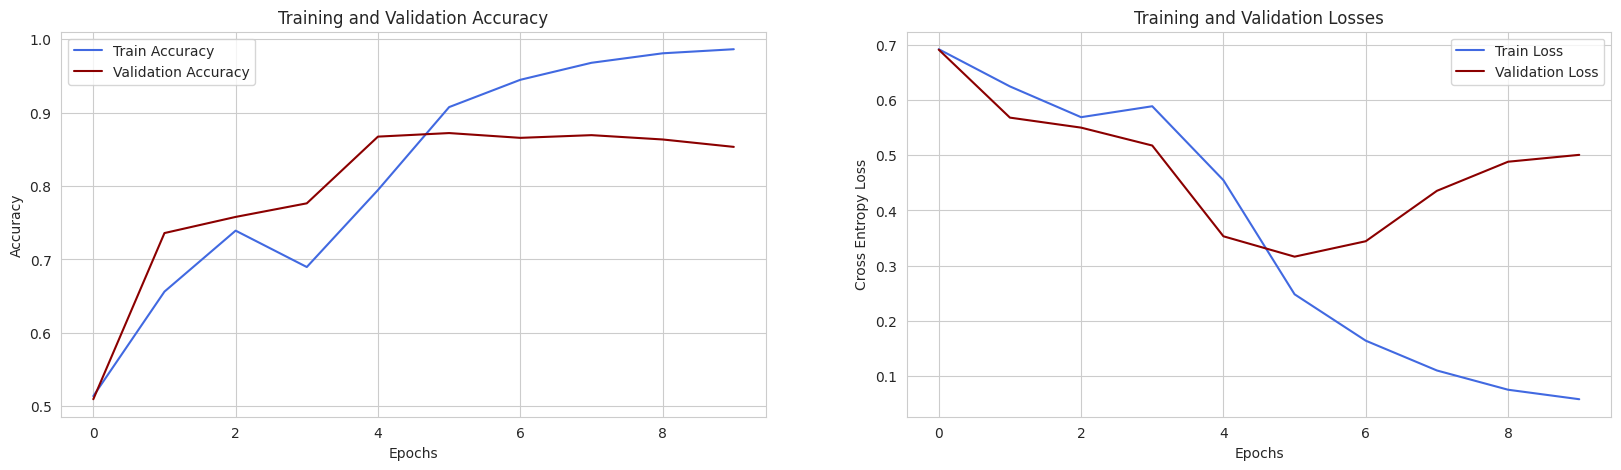

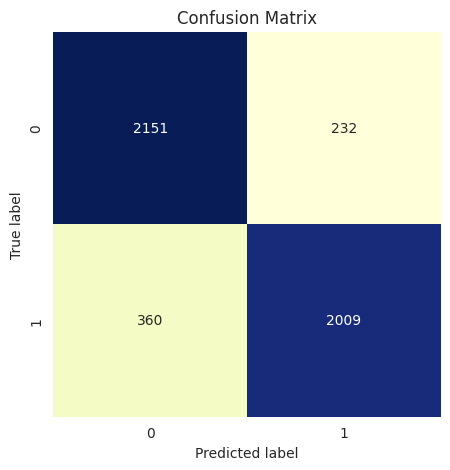

classification_report : 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2383
           1       0.90      0.85      0.87      2369

    accuracy                           0.88      4752
   macro avg       0.88      0.88      0.88      4752
weighted avg       0.88      0.88      0.88      4752



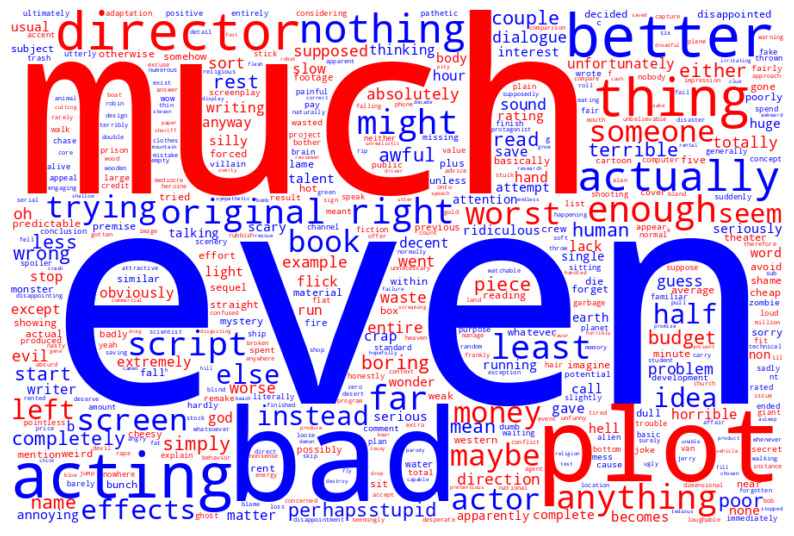

In [90]:
# model, test_pred = 
Model, Text = main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length,
         hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS,
         is_training = True, Visualize_Results = True)

# GRU Report

parameters

In [ ]:
type_of_rnn = 'GRU'
embedding_dim = 300
embedding_vector = '300'
fix_length = 200
hidden_dim_per_layer = [256,128]
output_dim = 2
dropout = 0.2
criterion = nn.CrossEntropyLoss()
LR = 0.001
N_EPOCHS = 5
batch_size = 128
model_name = 'GRU.pth'  # 'GRU' or 'RNN'

<IPython.core.display.Javascript object>

Number of training examples: 33265
Number of validation examples: 9505
Number of testing examples: 4752
Initialize_Network(
  (embedding): Embedding(28161, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): GRU(
      (W_x): Linear(in_features=300, out_features=512, bias=True)
      (U_h): Linear(in_features=256, out_features=512, bias=True)
      (W): Linear(in_features=300, out_features=256, bias=True)
      (U): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): GRU(
      (W_x): Linear(in_features=256, out_features=256, bias=True)
      (U_h): Linear(in_features=128, out_features=256, bias=True)
      (W): Linear(in_features=256, out_features=128, bias=True)
      (U): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Train Epoch: 1 / 5: 52000it [01:56, 447.39it/s]
Train Loss: 0.688293 | Validation Loss: 0.693813 | Train Accuracy: 0.52 | Validation Accuracy: 0.50
Train Epoch: 2 / 5: 52000it [01:53, 457.52it/s]
Train Loss: 0.688604 | Validation Loss: 0.549306 | Train Accuracy: 0.54 | Validation Accuracy: 0.73
Train Epoch: 3 / 5: 52000it [01:53, 457.08it/s]
Train Loss: 0.305184 | Validation Loss: 0.271248 | Train Accuracy: 0.87 | Validation Accuracy: 0.88
Train Epoch: 4 / 5: 52000it [01:53, 459.91it/s]
Train Loss: 0.176366 | Validation Loss: 0.292974 | Train Accuracy: 0.94 | Validation Accuracy: 0.88
Train Epoch: 5 / 5: 52000it [01:55, 450.40it/s]
Train Loss: 0.098722 | Validation Loss: 0.390119 | Train Accuracy: 0.97 | Validation Accuracy: 0.87


Test Loss is :  0.26907513525925186
Accuracy of the network on the 4752 test images: 88.85 %


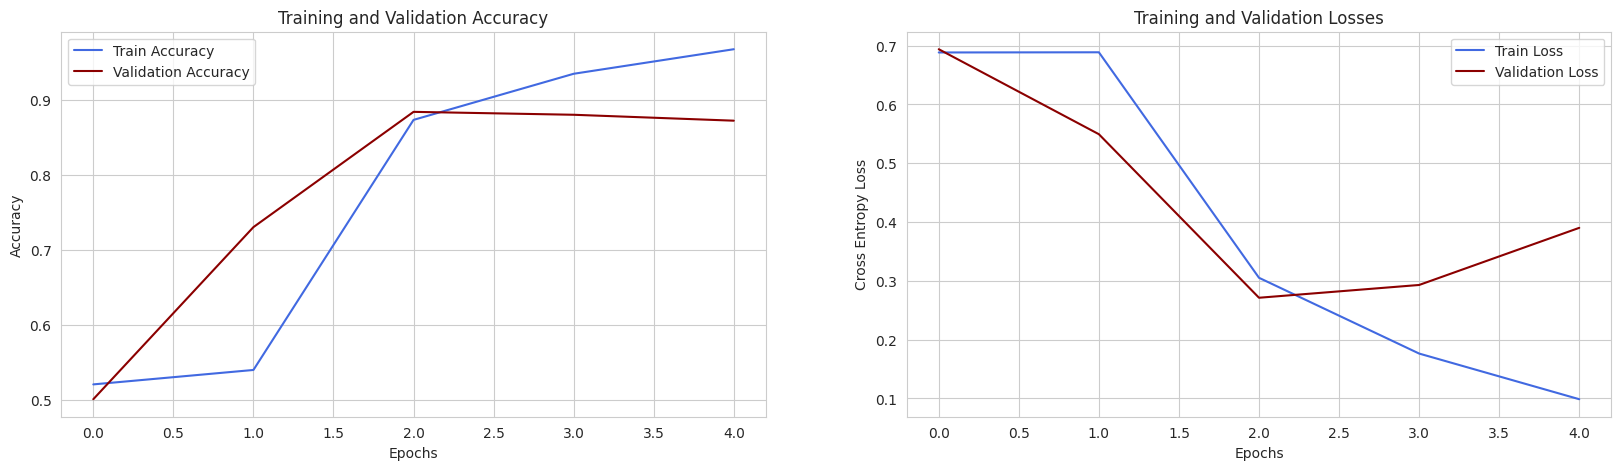

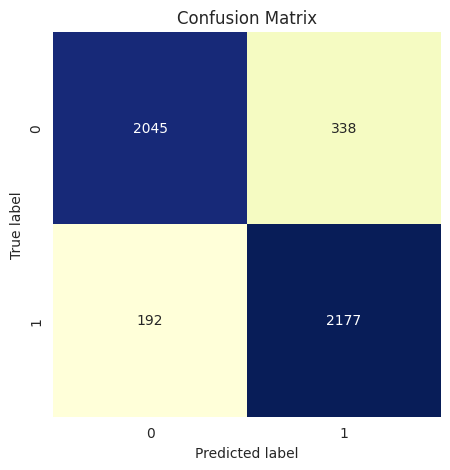

classification_report : 
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2383
           1       0.87      0.92      0.89      2369

    accuracy                           0.89      4752
   macro avg       0.89      0.89      0.89      4752
weighted avg       0.89      0.89      0.89      4752



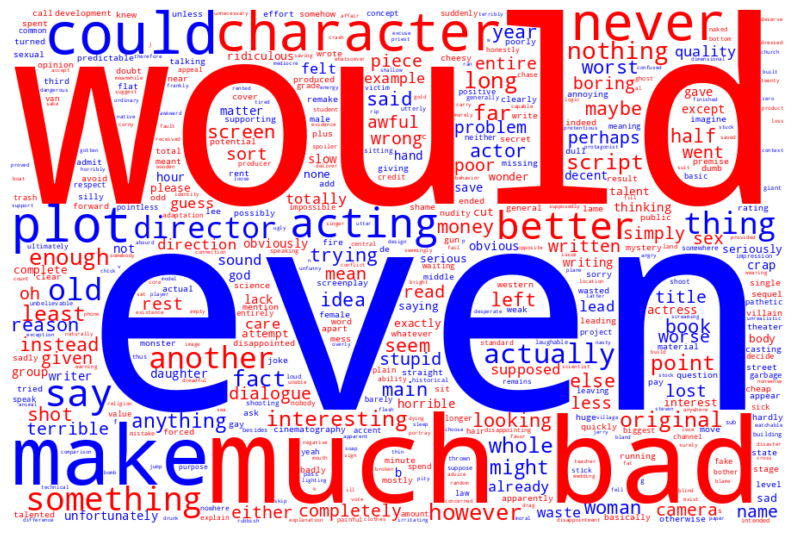

In [ ]:
# model, test_pred = 
Model, Text = main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length,
         hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS,
         is_training = True, Visualize_Results = True)

# LSTM Report

parameters

In [ ]:
type_of_rnn = 'LSTM'
embedding_dim = 300
embedding_vector = '300'
fix_length = 200
hidden_dim_per_layer = [256,128]
output_dim = 2
dropout = 0.2
criterion = nn.CrossEntropyLoss()
LR = 0.001
N_EPOCHS = 8
batch_size = 128
model_name = 'LSTM.pth'  # 'GRU' or 'RNN'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of training examples: 33265
Number of validation examples: 9505
Number of testing examples: 4752
Initialize_Network(
  (embedding): Embedding(28161, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): LSTM(
      (W_x): Linear(in_features=300, out_features=1024, bias=True)
      (W_h): Linear(in_features=256, out_features=1024, bias=True)
    )
    (1): LSTM(
      (W_x): Linear(in_features=256, out_features=512, bias=True)
      (W_h): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Train Epoch: 1 / 8: 52000it [01:18, 662.27it/s]
Train Loss: 0.685512 | Validation Loss: 0.673328 | Train Accuracy: 0.53 | Validation Accuracy: 0.51
Train Epoch: 2 / 8: 52000it [01:19, 651.99it/s]
Train Loss: 0.697156 | Validation Loss: 0.693089 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 8: 52000it [01:19, 656.26it/s]
Train Loss: 0.693023 | Validation Loss: 0.693157 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 8: 52000it [01:18, 658.60it/s]
Train Loss: 0.692891 | Validation Loss: 0.692957 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 5 / 8: 52000it [01:17, 671.17it/s]
Train Loss: 0.688881 | Validation Loss: 0.565385 | Train Accuracy: 0.52 | Validation Accuracy: 0.75
Train Epoch: 6 / 8: 52000it [01:16, 676.14it/s]
Train Loss: 0.355057 | Validation Loss: 0.293182 | Train Accuracy: 0.85 | Validation Accuracy: 0.88
Train Epoch: 7 / 8: 52000it [01:18, 665.19it/s]
Train Loss: 0.206764 | Validation Loss: 0.346526 | Train Accurac

Test Loss is :  0.29130171553084727
Accuracy of the network on the 4752 test images: 88.01 %


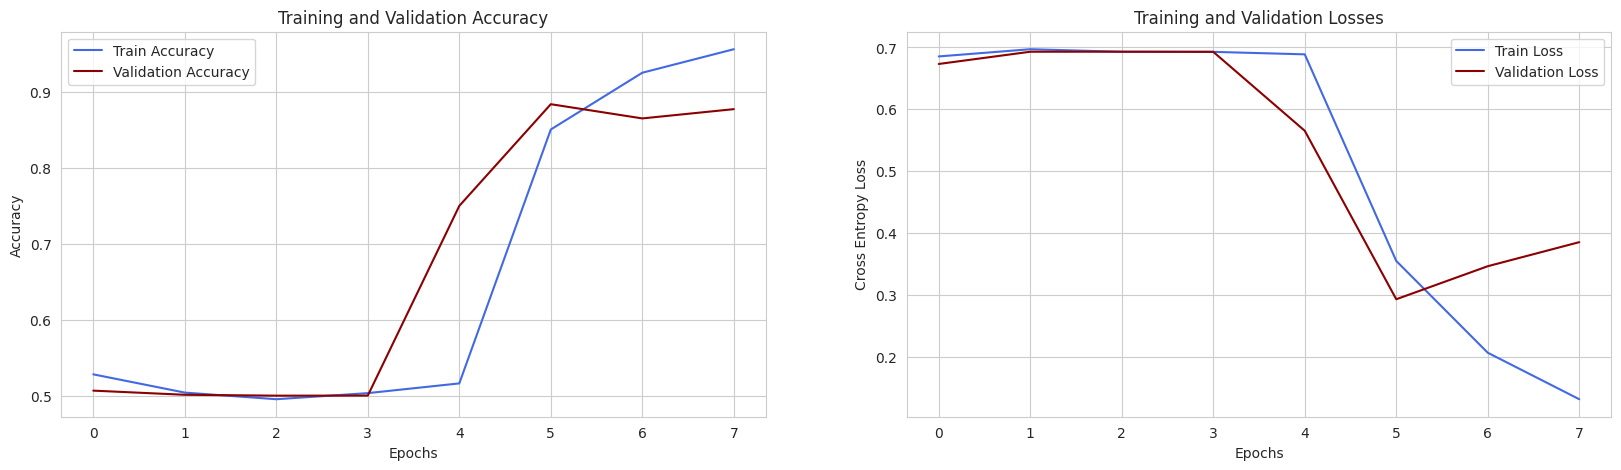

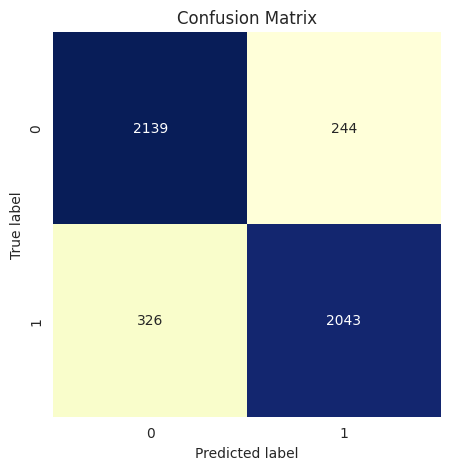

classification_report : 
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2383
           1       0.89      0.86      0.88      2369

    accuracy                           0.88      4752
   macro avg       0.88      0.88      0.88      4752
weighted avg       0.88      0.88      0.88      4752



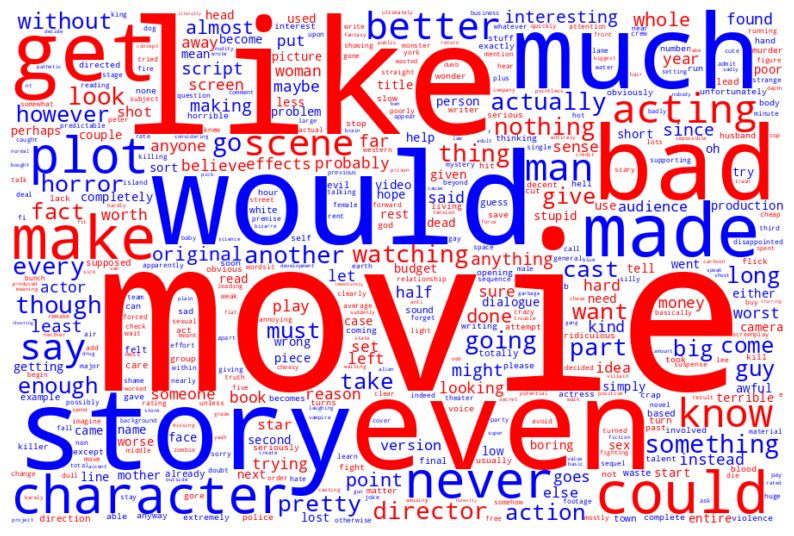

In [ ]:
# model, test_pred = 
Model, Text = main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length,
         hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS,
         is_training = True, Visualize_Results = True)

# LSTM Report_0.2

parameters

In [72]:
type_of_rnn = 'LSTM'
embedding_dim = 300
embedding_vector = '300'
fix_length = 200
hidden_dim_per_layer = [128,128]
output_dim = 2
dropout = 0.2
criterion = nn.CrossEntropyLoss()
LR = 0.001
N_EPOCHS = 12
batch_size = 128
model_name = 'LSTM.pth'  # 'GRU' or 'RNN'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of training examples: 33265
Number of validation examples: 9505
Number of testing examples: 4752
Initialize_Network(
  (embedding): Embedding(28161, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): LSTM(
      (W_x): Linear(in_features=300, out_features=512, bias=True)
      (W_h): Linear(in_features=128, out_features=512, bias=True)
    )
    (1): LSTM(
      (W_x): Linear(in_features=128, out_features=512, bias=True)
      (W_h): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Train Epoch: 1 / 12: 52000it [01:25, 609.20it/s]
Train Loss: 0.692799 | Validation Loss: 0.695841 | Train Accuracy: 0.51 | Validation Accuracy: 0.50
Train Epoch: 2 / 12: 52000it [01:29, 581.84it/s]
Train Loss: 0.693379 | Validation Loss: 0.692623 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 12: 52000it [01:25, 610.69it/s]
Train Loss: 0.690465 | Validation Loss: 0.692222 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 12: 52000it [01:26, 604.31it/s]
Train Loss: 0.680265 | Validation Loss: 0.680944 | Train Accuracy: 0.52 | Validation Accuracy: 0.52
Train Epoch: 5 / 12: 52000it [01:25, 607.29it/s]
Train Loss: 0.658144 | Validation Loss: 0.689079 | Train Accuracy: 0.56 | Validation Accuracy: 0.52
Train Epoch: 6 / 12: 52000it [01:25, 606.72it/s]
Train Loss: 0.501957 | Validation Loss: 0.525584 | Train Accuracy: 0.78 | Validation Accuracy: 0.79
Train Epoch: 7 / 12: 52000it [01:25, 610.06it/s]
Train Loss: 0.484337 | Validation Loss: 0.364295 | Train 

Test Loss is :  0.3094381662575822
Accuracy of the network on the 4752 test images: 87.61 %


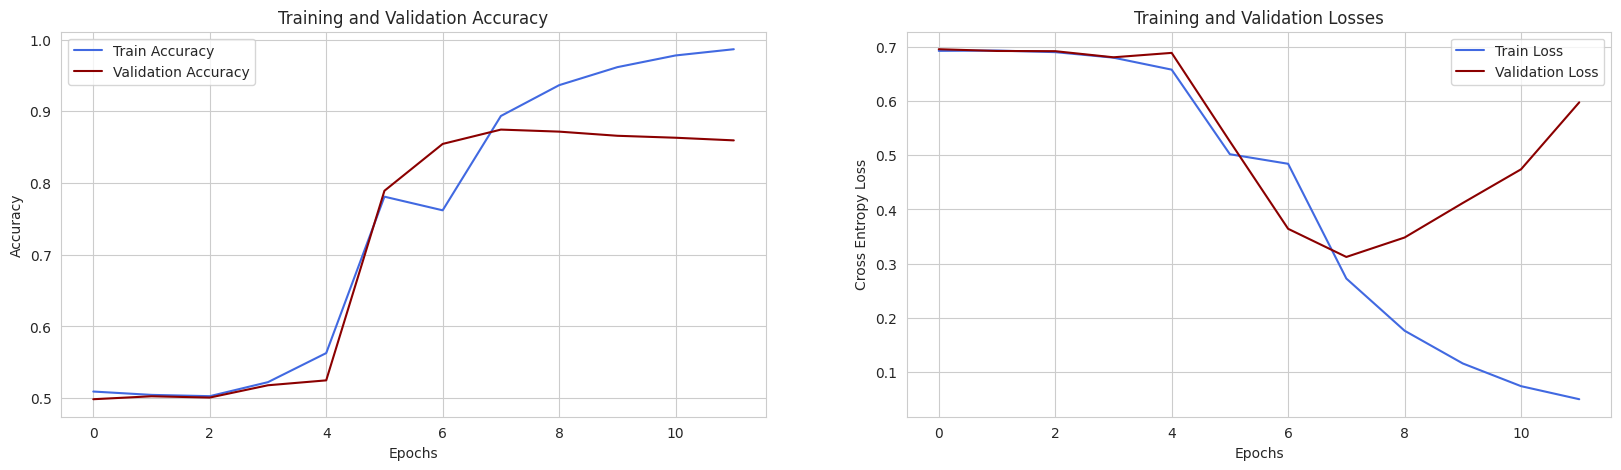

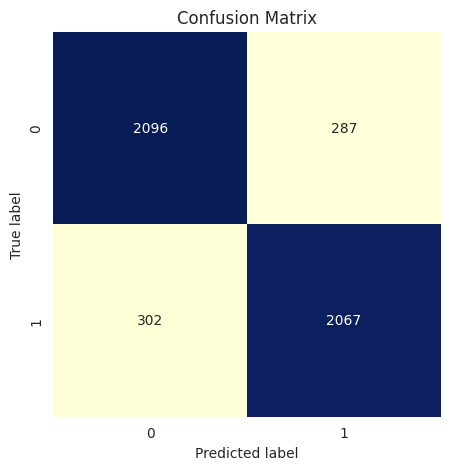

classification_report : 
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2383
           1       0.88      0.87      0.88      2369

    accuracy                           0.88      4752
   macro avg       0.88      0.88      0.88      4752
weighted avg       0.88      0.88      0.88      4752



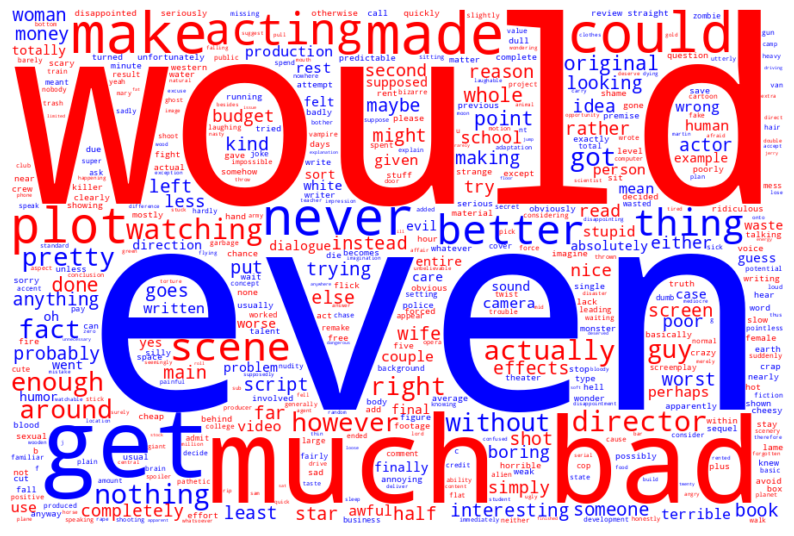

In [73]:
# model, test_pred = 
Model, Text = main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length,
         hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS,
         is_training = True, Visualize_Results = True)

# Predict Single Example

In [110]:
def predict(tweet, model, TEXT):
    model.eval()

    cliean_text = preprocess(tweet, english_words, stopwords)
    tokens = TEXT.tokenize(cliean_text)
    tensor = TEXT.process([tokens])

    prediction = model(tensor[0].to(device))
    predicted = torch.max(prediction.data)

    if predicted == 1:
        print("Positive sentiment")
    else:
        print("Negative sentiment")


<IPython.core.display.Javascript object>

In [111]:
tweet = 'that was the worst movie I have ever seen in my life'
predict(tweet, Model, Text)

<IPython.core.display.Javascript object>

Negative sentiment
